# Exercício de Extreme Learning Machines

In [11]:
import numpy as np
import matplotlib.pyplot as plt

### Exercício 1


In [12]:
#Gerando dados sinteticos
np.random.seed(2002)
n = 30

x1 = np.random.normal(loc = 1.5,size=n)

y1 = np.random.normal(loc = 1.5,size=n)

x2 = np.random.normal(loc = 3,size=n)

y2 = np.random.normal(loc = 3, size=n)

x = np.vstack([
    np.column_stack([x1,y1]),
    np.column_stack([x2,y2])
    ])

x = np.column_stack([np.ones(len(x)),x])
y = np.hstack([
    -1*np.ones(len(x1),dtype=np.int8),
    np.ones(len(x1),dtype=np.int8),
    
    ])

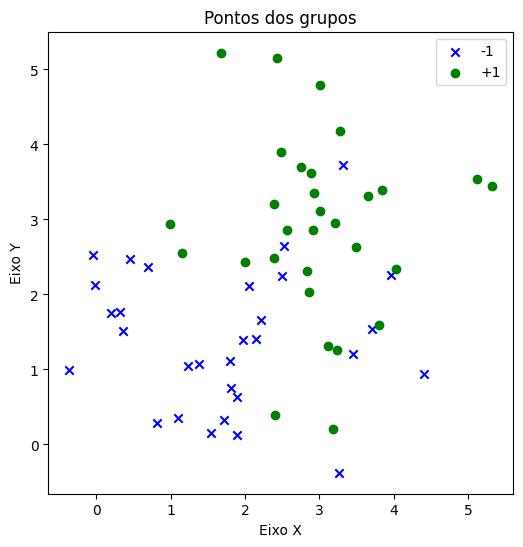

In [13]:
#Plotando dados
plt.figure(figsize=(6,6))

plt.scatter(x=x1,y=y1,color = 'blue',label = '-1',marker= 'x')
plt.scatter(x=x2,y=y2,color = 'green',label = '+1', marker='o')

plt.title("Pontos dos grupos")
plt.xlabel("Eixo X")
plt.ylabel("Eixo Y")
plt.legend()

plt.show()

In [14]:
def ajuste(x, y, Z, lamb = 0.1 ,not_intercept = False):
    
    
    if(not_intercept == True):
        x = np.column_stack([
            np.ones(len(x)),
            x
        ])
        
    H = np.tanh(x@Z)
    w = np.linalg.inv(np.transpose(H) @ H - lamb * np.identity(H.shape[1])) @ np.transpose(H) @ y
    return w

def predict(x,w,Z):
    H = np.tanh(x@Z)
    y = H@w

    return y


In [15]:

Z = np.random.uniform(low=-1,high=1 , size=(3,30))
w = ajuste(x,y,Z,lamb=0.01)

y_hat = predict(x,w,Z)

In [16]:
def plot_contorno(x, y, Z, lambs, not_intercept=False):

    if not_intercept:
        x = np.column_stack([np.ones(len(x)), x])

    # Camada oculta
    H = np.tanh(x @ Z)

    # Grid no plano 2D original
    x_min, x_max = x[:,1].min()-0.5, x[:,1].max()+.5
    y_min, y_max = x[:,2].min()-.5, x[:,2].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_aug = np.c_[np.ones(grid_points.shape[0]), grid_points]  # adiciona intercepto
    grid_proj = np.tanh(grid_aug @ Z)

    # Para cada lambda, ajusta o separador e plota
    for lamb in lambs:
        w = ajuste(x, y, Z, lamb)
        scores = np.tanh(grid_proj @ w)
        z = scores.reshape(xx.shape)

        plt.figure(figsize=(6,6))
        plt.contourf(xx, yy, z, levels=[-np.inf,0,np.inf], alpha=0.2, colors=["blue","green"])
        plt.contour(xx, yy, z, levels=[0], colors="k", linewidths=2)

        plt.scatter(x[y==-1,1], x[y==-1,2], color="blue", label="-1", marker= 'x')
        plt.scatter(x[y==+1,1], x[y==+1,2], color="green", label="+1",marker='o')

        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title(r"Separador para $\lambda = {}$".format(lamb))
        plt.legend()
        plt.show()

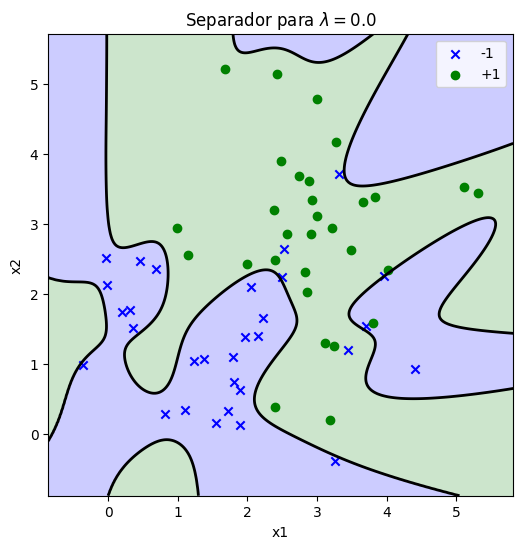

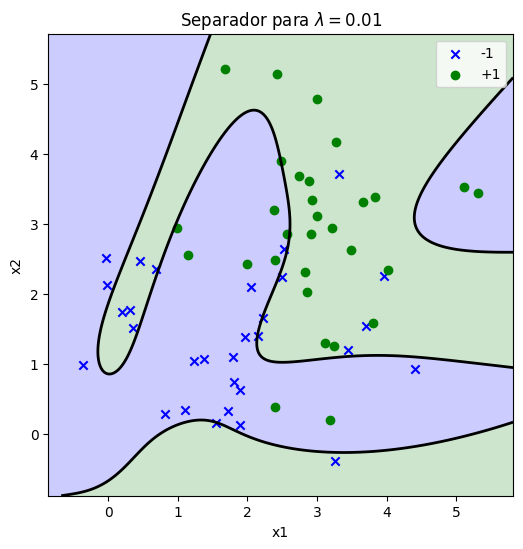

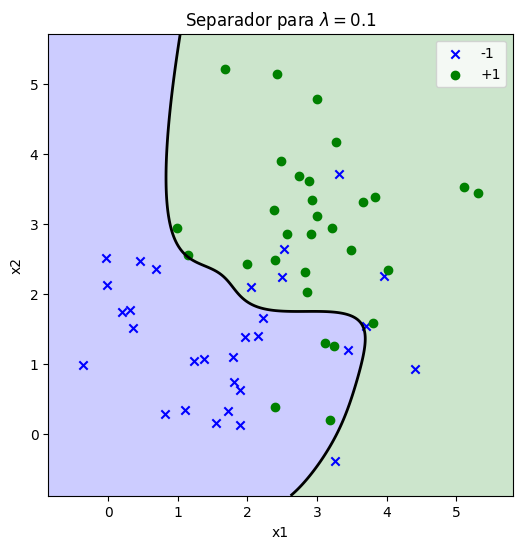

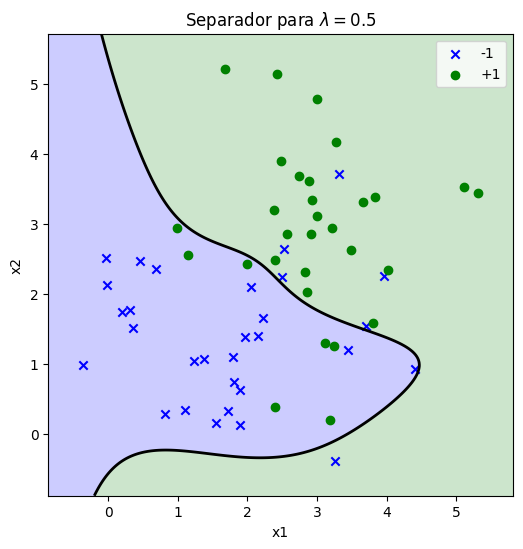

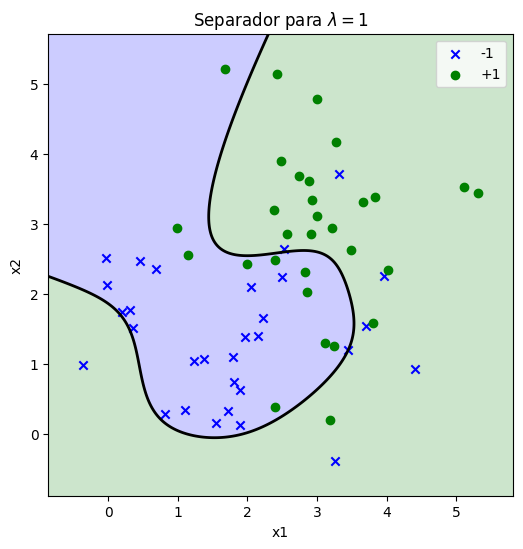

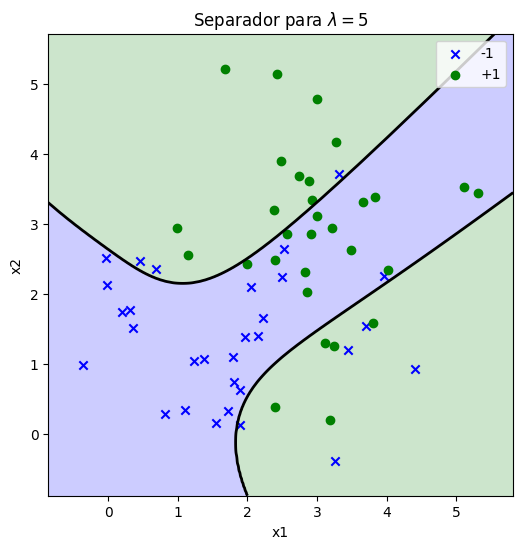

In [17]:
plot_contorno(x,y,Z,lambs= [0.0,0.01,0.1,0.5,1,5])

## Discussão

Foi adotada a seguinte sequencia para ajuste: 

$$ X \to XZ \to H = tanh(XZ) \to w = (H'H - \lambda I)^{-1}H'y $$


A função tanh permite projetar X em um espaço de dimensão maior de forma não-linear, o que é essencial para tornar as observações linearmente separáveis. 

Optou-se por uma projeção de dimensão elevada justamente para forçar o overfitting. Observa-se que, para $\lambda = 0$, diversos pontos do conjunto de dados residem exatamente na fronteira de separação, refletindo o ajuste excessivo do modelo aos dados de treino. À medida que $\lambda$ aumenta, as curvas de separação tornam-se progressivamente mais suaves, reduzindo o overfit até que, para valores muito grandes de $\lambda$, ocorre underfitting.

### Exercício 2


In [18]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

data = load_breast_cancer()
X = data.data
y = data.target  # 0 = malignant, 1 = benign

# Split estratificado (mesmo que você usou)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=40
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

X_train = np.column_stack([np.ones(len(X_train)), X_train])
X_test  = np.column_stack([np.ones(len(X_test)),  X_test])




In [19]:

#Classe de extreme learning machine


class ELM:
   
    def __init__(self, Z_dim, random_state=0):
        
        self.weights = None     # beta (n_hidden, 1)
        self.Z = None           # W (n_features, n_hidden)
        self._Z_dim = Z_dim
        
        self.random_state = random_state

    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    

    def fit(self, X, y, lamb):
        n_samples, n_features = X.shape
        rng = np.random.RandomState(self.random_state)

        # Inicializa W (self.Z)
        if isinstance(self._Z_dim, int):
            n_hidden = self._Z_dim
            self.Z = rng.uniform(low=-1.5, high=1.5, size=(n_features, n_hidden))
        else:
            # Espera [n_features, n_hidden]
            n_feat_Z, n_hidden = int(self._Z_dim[0]), int(self._Z_dim[1])
            if n_feat_Z != n_features:
                raise ValueError(
                    f"Incompatibilidade: X tem {n_features} colunas, mas Z_dim pede {n_feat_Z}."
                )
            self.Z = rng.uniform(low=-1.5, high=1.5, size=(n_features, n_hidden))

        # Saída da camada oculta
        H = self._sigmoid(X @ self.Z)  # (n_samples, n_hidden)
        H = np.column_stack([
            np.ones(len(H)),
            H
        ])
        # Ridge: beta = (H^T H + λ I)^-1 H^T y   (use solve para estabilidade)
        y_col = y.reshape(-1, 1).astype(float)
        A = H.T @ H + lamb * np.eye(H.shape[1])
        B = H.T @ y_col
        self.weights = np.linalg.solve(A, B)  # (n_hidden, 1)
        return self

    def predict_proba(self, X):
        H = self._sigmoid(X @ self.Z)
        
        H = np.column_stack([
            np.ones(len(H)),
            H
        ])

        z = (H @ self.weights).ravel()
        p1 = 1.0 / (1.0 + np.exp(-z))  # prob da classe 1
        # retorna formato sklearn-like: [P(0), P(1)]
        return np.column_stack([1 - p1, p1])

    def predict(self, X, threshold=0.5):
        p1 = self.predict_proba(X)[:, 1]
        return (p1 >= threshold).astype(int)


def avalia(elm, X_tr, y_tr, X_te, y_te, nome=""):
    y_pred_tr = elm.predict(X_tr)
    y_pred_te = elm.predict(X_te)

   
    acc_tr = accuracy_score(y_tr, y_pred_tr)
    acc_te = accuracy_score(y_te, y_pred_te)
    

    print(f"\n=== {nome} ===")
    print(f"Train -> Acc: {acc_tr:.4f} ")
    print(f"Test  -> Acc: {acc_te:.4f} ")
  


In [22]:


lambs = [0.0, 0.001,0.01,0.1,0.5,1,2,3]
for lam in lambs:
    elm = ELM([X_train.shape[1], 38], random_state=41)
    elm.fit(X_train, y_train, lam)
    avalia(elm, X_train, y_train, X_test, y_test, nome=f"ELM (n_hidden=500, λ={lam})")



=== ELM (n_hidden=500, λ=0.0) ===
Train -> Acc: 0.7789 
Test  -> Acc: 0.7427 

=== ELM (n_hidden=500, λ=0.001) ===
Train -> Acc: 0.7789 
Test  -> Acc: 0.7427 

=== ELM (n_hidden=500, λ=0.01) ===
Train -> Acc: 0.7789 
Test  -> Acc: 0.7427 

=== ELM (n_hidden=500, λ=0.1) ===
Train -> Acc: 0.7764 
Test  -> Acc: 0.7427 

=== ELM (n_hidden=500, λ=0.5) ===
Train -> Acc: 0.7739 
Test  -> Acc: 0.7368 

=== ELM (n_hidden=500, λ=1) ===
Train -> Acc: 0.7613 
Test  -> Acc: 0.7427 

=== ELM (n_hidden=500, λ=2) ===
Train -> Acc: 0.7638 
Test  -> Acc: 0.7485 

=== ELM (n_hidden=500, λ=3) ===
Train -> Acc: 0.7714 
Test  -> Acc: 0.7602 


À medida que o parâmetro de regularização $\lambda$ aumenta, o modelo tende a se tornar mais simples e menos suscetível ao \textit{overfitting}, o que resulta em uma melhora no desempenho sobre o conjunto de teste. 
No entanto, a partir de um certo ponto, valores muito altos de $\lambda$ fazem com que o modelo se torne excessivamente restrito, incapaz de capturar os padrões relevantes dos dados. 
Assim, o desempenho no conjunto de teste volta a piorar, evidenciando a necessidade de escolher um valor intermediário de $\lambda$ que equilibre viés e variância, maximizando a capacidade de generalização do modelo.
